In [1]:
"Based on the fp_transition_matrix in 2nd step, single cell trajectories are simulated with the transition matrix. "

'Based on the fp_transition_matrix in 2nd step, single cell trajectories are simulated with the transition matrix. '

In [2]:
import scvelo as scv
import pandas as pd 
import numpy as np
from anndata import AnnData
import loompy
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import matplotlib.patches as mpatches
import pickle
import os
import leidenalg
from scipy import sparse
from IPython.display import SVG
from sklearn.linear_model import LinearRegression
from scipy import stats,signal
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.cluster import KMeans

from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from scipy.sparse import issparse
from scvelo.preprocessing.utils import get_mean_var,materialize_as_ndarray

In [3]:
L = 6
# data_name = "EG_ab_bin1"
# data_name = "DG_bin_ppt"
data_name = "zebrafish_dynamo_part"
# data_name = "zebrafish_dynamo_C_6_282_cs_cut_0.65"

fp_path=f'result/{data_name}/'
adata=scv.read(fp_path + f'{data_name}_fp.h5ad')

adata

AnnData object with n_obs × n_vars = 3386 × 600
    obs: 'split_id', 'sample', 'Size_Factor', 'condition', 'Cluster', 'Cell_type', 'umap_1', 'umap_2', 'batch', 'n_counts', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'ntr'
    var: 'n_cells', 'gene_count_corr', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'nCells', 'nCounts', 'pass_basic_filter', 'frac', 'use_for_pca', 'ntr', 'beta', 'gamma', 'half_life', 'alpha_b', 'alpha_r2', 'gamma_b', 'gamma_r2', 'gamma_logLL', 'delta_b', 'delta_r2', 'bs', 'bf', 'uu0', 'ul0', 'su0', 'sl0', 'U0', 'S0', 'total0', 'use_for_dynamics', 'use_for_transition'
    uns: 'Cell_type_colors', 'PCs', 'dynamics', 'explained_variance_ratio_', 'feature_selection', 'grid_velocity_pca', 'hvg', 'log1p', 'neighbors', 'pca', 'pca_fit', 'pca_mean', 'pp', 'umap'
    obsm: 'X', 'X_pca', 'X_umap', 'velocity_pca'
    varm: 'PCs'
    layers: 'M_s', 'M_ss', 'M_u', 'M_us', 'M_uu', 'Ms', 'Mu', 'X_Ms', 'X_Mu', 'X_spliced', 'X_unspliced', 'spliced', 'unspli

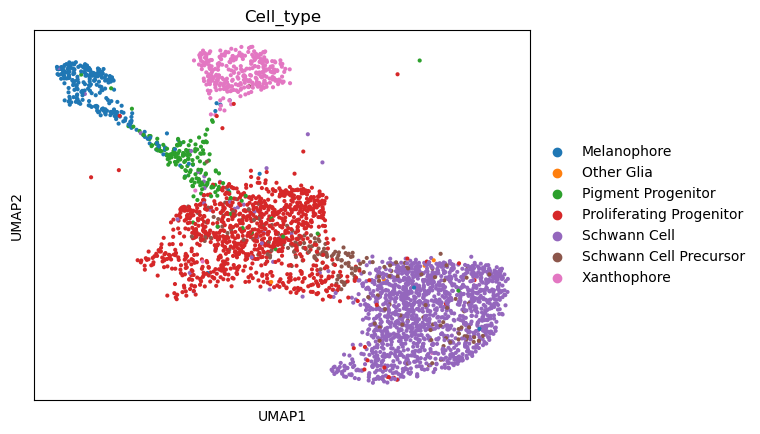

['Schwann Cell', 'Melanophore', 'Schwann Cell Precursor', 'Proliferating Progenitor', 'Xanthophore', 'Pigment Progenitor', 'Other Glia']
Categories (7, object): ['Melanophore', 'Other Glia', 'Pigment Progenitor', 'Proliferating Progenitor', 'Schwann Cell', 'Schwann Cell Precursor', 'Xanthophore']

In [4]:
import scanpy as sc
sc.pl.umap(adata, color = "Cell_type")
adata.obs["Cell_type"].unique()

In [5]:
branch_name = "Schwann Cell"
result_path= fp_path + f'{branch_name}'
adata.uns['velocity_graph']=adata.obsp['fp_transition_matrix']  # (3386, 3386)
# t_list=np.array(['Ngn3 low EP', 'Ngn3 high EP', 'Fev+', 'Alpha'])  # 一支数据
# t_list=np.array(['RadialGlia','nIPC', 'Nbl1', 'Nbl2', 'ImmGranule1', 'ImmGranule2', 'Granule' ])
# t_list=np.array(['Proliferating Progenitor', 'Pigment Progenitor', 'Xanthophore'])
# t_list=np.array(['Proliferating Progenitor', 'Pigment Progenitor', 'Melanophore'])
t_list=np.array(['Proliferating Progenitor', 'Schwann Cell Precursor', 'Schwann Cell'])

In [6]:
"transition matrix of single cell"

'transition matrix of single cell'

In [7]:
T=adata.obsp['fp_transition_matrix']  # NOTE: (3386, 3386) 这是细胞-细胞转移概率矩阵

In [8]:
# NOTE: 这里用的是X_pca计算的距离。
adata.obs['clusters'] = adata.obs['Cell_type']
source_mean=np.mean(adata[(np.array(adata.obs['clusters'].tolist())==t_list[0]),:].obsm['X_pca'],axis=0) # shape(30, ). source cluster每维pca的均值.
target_mean=np.mean(adata[(np.array(adata.obs['clusters'].tolist())==t_list[-1]),:].obsm['X_pca'],axis=0) #target cluster每维pca的均值.
snodes=np.argsort(np.linalg.norm(adata.obsm['X_pca']-source_mean,axis=1))[:100] # start nodes. np.argsort是从小到大排序. snodes是离source cluster的均值细胞最近的100个细胞

tnodes=np.argsort(np.linalg.norm(adata.obsm['X_pca']-target_mean,axis=1))[:10] # end nodes. snodes是离target cluster的均值细胞最近的10个细胞

In [9]:
def consecutive_arrs(data, stepsize=1):
    return np.split(data, np.where(np.diff(data)>stepsize)[0]+1)

In [10]:
#----adapted from scvelo----------
def get_cell_transitions(
    
    adata,
    T=T,
    starting_cell=0,
    basis=None,
    n_steps=100,
    n_neighbors=30,
    backward=False,
    random_state=None,
    **kwargs,
):
    """Simulate cell transitions(trajectory)
    Arguments
    ---------
    adata: :class:`~anndata.AnnData`
        Annotated data matrix.
    starting_cell: `int` (default: `0`)
        Index (`int`) or name (`obs_names) of starting cell.
    n_steps: `int` (default: `100`)
        Number of transitions/steps to be simulated.
    backward: `bool` (default: `False`)
        Whether to use the transition matrix to
        push forward (`False`) or to pull backward (`True`)
    random_state: `int` or `None` (default: `None`)
        Set to `int` for reproducibility, otherwise `None` for a random seed.
    **kwargs:
        To be passed to tl.transition_matrix.
    Returns
    -------
    Returns embedding coordinates (if basis is specified),
    otherwise return indices of simulated cell transitions.
    """

    np.random.seed(random_state)
    if isinstance(starting_cell, str) and starting_cell in adata.obs_names:
        starting_cell = adata.obs_names.get_loc(starting_cell)
    X = [starting_cell]
    for _ in range(n_steps):
        t = T[X[-1]] # sparse matrix 有indices和data,分别存的列索引和对应的数值.
        indices, p = t.indices, t.data
        if n_neighbors is not None and n_neighbors < len(p):
            idx = np.argsort(t.data)[::-1][:n_neighbors]
            indices, p = indices[idx], p[idx]
        if len(p) == 0:
            indices, p = [X[-1]], [1]
        p /= np.sum(p) # 归一化
        ix = np.random.choice(indices, p=p) # 从indices抽取一个元素. p指indices各元素被选中的概率.

        if (adata.obs['Cell_type'][ix]) in t_list and (np.where(t_list == adata.obs['Cell_type'][ix])[0][0] - np.where(t_list == adata.obs['Cell_type'][X[-1]])[0][0] in [0, 1]):
            X.append(ix) # 只允许相邻细胞状态跳转

    X = pd.unique(X)
    if basis is not None and f"X_{basis}" in adata.obsm.keys():
        X = adata.obsm[f"X_{basis}"][X].T
    if backward:
        X = np.flip(X, axis=-1)
    return X

In [11]:
dwell_thres=5
traj_arrs=[] # 里面的每个元素对应一条轨迹各点的umap坐标.
traj_seri=[] # 里面的每个元素对应一条轨迹各点adata索引.
adata_arrs=[] # 里面的每个元素对应一条轨迹各点adata.
for sn in snodes:
    if not (adata.obs['Cell_type'][sn] in t_list):
        print(f"{sn}这个细胞不在这支路径上.") # 这是因为有别的cluster的细胞离source cluster均值的细胞比较近.
        continue # 他的作用跳出循环,跳过这个sn细胞.
    traj_ind=get_cell_transitions(adata, starting_cell=sn, n_steps=600)  # traj_ind是细胞的索引
    traj_t=np.array(adata[traj_ind,:].obs['clusters'].values)
    if len(np.where(traj_t==t_list[-1])[0])>0:
        F_arrs=consecutive_arrs(np.where(traj_t==t_list[-1])[0]) # 这样F_arr是全部连续的处在tnodes中的序号序列 的序列  
        # NOTE: F_arrs是一个列表,列表内的每个元素都是一段连续的索引. 有多个元素是因为细胞从最后一个cluster跳回了前一个cluster.
        
        end_t=0
        n=len(F_arrs)
        while n>=1:
            # 如果连续10步都在tnodes中，就认为已经游走收敛到末细胞态的well中了
            if F_arrs[n-1].shape[0]>dwell_thres:
                end_t=F_arrs[n-1][-1]
                break
            n-=1

        if end_t>0:
            traj_seri.append(traj_ind[:end_t])
            # NOTE：这里用umap是为了后面的代码块。后面需要在umap坐标系上可视化选出的traj是怎样的。
            traj=np.array(adata[traj_ind[:end_t],:].obsm['X_umap'])
            traj_arrs.append(traj)
            adata_traj=adata[traj_ind[:end_t],:]
            adata_arrs.append(adata_traj)

1483这个细胞不在这支路径上.


In [12]:
print(len(traj_arrs))

78


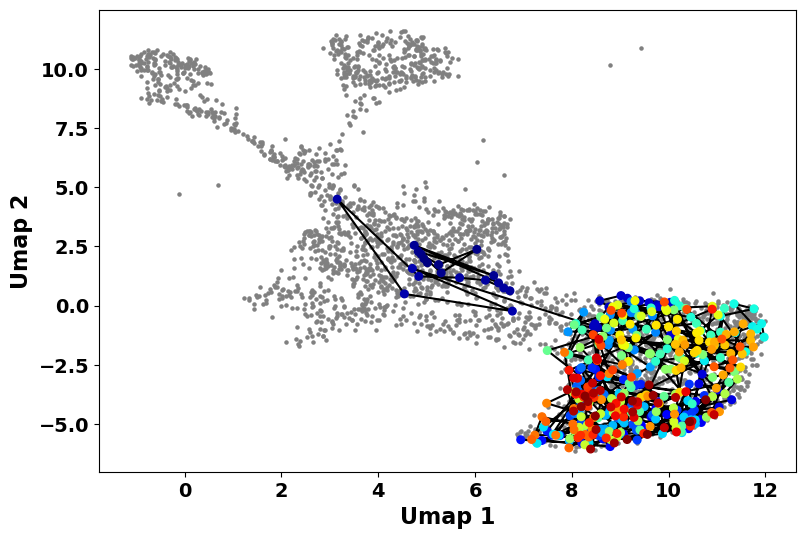

In [13]:
fig,ax=plt.subplots(figsize=(9,6))

# plt.scatter(adata.obsm['X_pca'][:,0],adata.obsm['X_pca'][:,1],s=5,c=np.unique(adata.obs['sample'], return_inverse=True)[1],cmap='jet')
plt.scatter(adata.obsm['X_umap'][:,0],adata.obsm['X_umap'][:,1],s=5,color='grey')

color_arr=['black']
for i in range(1):#(len(traj_arrs)):
    
    plt.plot(traj_arrs[i][:,0],traj_arrs[i][:,1],color=color_arr[i])
    dot_color=np.arange(traj_arrs[i].shape[0])
    
    plt.scatter(traj_arrs[i][:,0],traj_arrs[i][:,1],s=30,c=dot_color,cmap=plt.cm.jet,zorder=10)
plt.xlabel('Umap 1',fontsize=16,fontweight='bold')
plt.ylabel('Umap 2',fontsize=16,fontweight='bold')
plt.xticks(fontsize=14,fontweight='bold')
plt.yticks(fontsize=14,fontweight='bold')
# plt.savefig(result_path+'EG_traj.png',dpi=300)
plt.show()

In [14]:
if not os.path.exists(f'{result_path}/{data_name}_P2M_traj'):
    os.makedirs(f'{result_path}/{data_name}_P2M_traj')
for i in range(len(traj_arrs)):
#       np.save('result/emt_dyn_traj/'+str(i)+'.npy',traj_arrs[i])
    adata_arrs[i].uns = {}
    adata_arrs[i].write_h5ad(f'{result_path}/{data_name}_P2M_traj/{i}.h5ad')

In [15]:
len(traj_arrs)

78